<a href="https://colab.research.google.com/github/Ronny5/TSAI_EVA_REPO/blob/master/S8_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment 7**

**The Given task was to fix the given model with the below keypoints and improvements.**

1. Fix the network above:
2. change the code such that it uses GPU
3. change the architecture to C1C2C3C40 (basically 3 MPs)
4. total RF must be more than 44
5. one of the layers must use Depthwise Separable Convolution
6. one of the layers must use Dilated Convolution
7. use GAP (compulsory):- add FC after GAP to target #of classes (optional)
8. achieve 80% accuracy, as many epochs as you want. Total Params to be less  than 1M. 
10. upload to Github

**Another task was to modularize the code to a repository in Github**


## **Model Description**

###**Target:** 
80% accuracy with less than 1 million parameters

###**Results:**
Parameters: 733k (<1M)

**Best Train Accuracy:** 83.19

**Best Test Accuracy:** 82.68 (9th Epoch)

**Analysis:** This model has scope of improvement. Dropout and Augumentation was used to avoid overfillting.


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.



###Cloning the GITHUB repository for Session 7 Assignment

In [1]:
!rm -rf /content/TSAI_EVA_REPO/

In [2]:
!pwd

/content


In [3]:
!git clone https://github.com/Ronny5/TSAI_EVA_REPO.git

Cloning into 'TSAI_EVA_REPO'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 143 (delta 61), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (143/143), 574.51 KiB | 9.42 MiB/s, done.
Resolving deltas: 100% (61/61), done.


### Executing required modules from the Github clone

In [4]:
import TSAI_EVA_REPO.Utils.s7_utils as util
import TSAI_EVA_REPO.Models.Resnet as model
import TSAI_EVA_REPO.Training.train as trn
import TSAI_EVA_REPO.Testing.test as tst
import TSAI_EVA_REPO.Misc.Misc as misc


### Calculating True Mean and STD for the CIFAR10 dataset (Train & Test combined)

In [5]:
# Calling the function to calculate the mean and standard deviation for the mentioned dataset

norm_mean, norm_std = util.cifar10_mean_std()
print(norm_mean, norm_std)

Files already downloaded and verified
Files already downloaded and verified
(0.49, 0.48, 0.45) (0.25, 0.24, 0.26)


In [6]:
train_transform = util.train(norm_mean, norm_std)
test_transform = util.test(norm_mean, norm_std)
print(train_transform, test_transform)

Compose(
    RandomRotation(degrees=(-5.0, 5.0), resample=False, expand=False, fill=(1, 1, 1))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
) Compose(
    ToTensor()
    Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
)


In [7]:
# Extract and transform the data

train_set = trn.s7train(train_transform)
test_set  = tst.test(test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# Dataloader Arguments & Test/Train Dataloaders - Loading into the GPU
import torch
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
    
# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=1)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
# test dataloader
test_loader  = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


airplane   dog  deer  deer


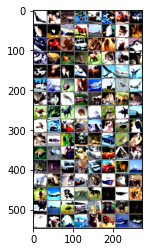

In [10]:
misc.samplegrid(train_loader,classes)

### Defining a Deep Convolution NN



In [11]:
# from torchsummary import summary

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


models = model.ResNet18().to(device)
summary(models, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when we start your training loop, ideally we should zero out the gradients so that we do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(models.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(models, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(models, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.5170443058013916 Batch_id=390 Train Accuracy=35.95: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.5071, Test Accuracy: 4909/10000 (49.09%)

EPOCH: 1


Loss=1.265380859375 Batch_id=390 Train Accuracy=54.46: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.6273, Test Accuracy: 6148/10000 (61.48%)

EPOCH: 2


Loss=0.849945068359375 Batch_id=390 Train Accuracy=64.55: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.7587, Test Accuracy: 6764/10000 (67.64%)

EPOCH: 3


Loss=0.8469192385673523 Batch_id=390 Train Accuracy=71.29: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.1624, Test Accuracy: 7303/10000 (73.03%)

EPOCH: 4


Loss=0.58366858959198 Batch_id=390 Train Accuracy=75.98: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8719, Test Accuracy: 7560/10000 (75.60%)

EPOCH: 5


Loss=0.4645816683769226 Batch_id=390 Train Accuracy=79.43: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8494, Test Accuracy: 7863/10000 (78.63%)

EPOCH: 6


Loss=0.4347374439239502 Batch_id=390 Train Accuracy=82.24: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9935, Test Accuracy: 7878/10000 (78.78%)

EPOCH: 7


Loss=0.5766754150390625 Batch_id=390 Train Accuracy=84.66: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3894, Test Accuracy: 8174/10000 (81.74%)

EPOCH: 8


Loss=0.438396692276001 Batch_id=390 Train Accuracy=86.51: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4560, Test Accuracy: 8164/10000 (81.64%)

EPOCH: 9


Loss=0.3326124846935272 Batch_id=390 Train Accuracy=88.13: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.2159, Test Accuracy: 8230/10000 (82.30%)

EPOCH: 10


Loss=0.2669834494590759 Batch_id=390 Train Accuracy=93.09: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -11.7878, Test Accuracy: 8608/10000 (86.08%)

EPOCH: 11


Loss=0.2522837519645691 Batch_id=390 Train Accuracy=94.41: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -12.3188, Test Accuracy: 8646/10000 (86.46%)

EPOCH: 12


Loss=0.293840229511261 Batch_id=390 Train Accuracy=95.24: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -13.4331, Test Accuracy: 8669/10000 (86.69%)

EPOCH: 13


Loss=0.061125773936510086 Batch_id=390 Train Accuracy=95.67: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -13.8281, Test Accuracy: 8687/10000 (86.87%)

EPOCH: 14


Loss=0.07913131266832352 Batch_id=390 Train Accuracy=96.32: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -14.7618, Test Accuracy: 8638/10000 (86.38%)

EPOCH: 15


Loss=0.05075959116220474 Batch_id=390 Train Accuracy=96.82: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -15.6727, Test Accuracy: 8658/10000 (86.58%)

EPOCH: 16


Loss=0.07016777992248535 Batch_id=390 Train Accuracy=97.04: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -15.8995, Test Accuracy: 8656/10000 (86.56%)

EPOCH: 17


Loss=0.10726298391819 Batch_id=169 Train Accuracy=97.42:  43%|████▎     | 170/391 [00:28<00:36,  6.13it/s]

KeyboardInterrupt: ignored